<a href="https://colab.research.google.com/github/goelnikhils-lgtm/languagemodels/blob/main/Reinforcement_Learning_Fine_Tuning_of_LLM_Sample_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#RLHF based fine tuning - sample code but not working code
#credit - https://medium.com/@meeran03/fine-tuning-llms-with-human-feedback-rlhf-latest-techniques-and-best-practices-3ed534cf9828
#credit - https://www.youtube.com/watch?v=R2paulc3P2M

In [ ]:
!pip install trl
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from transformers import AutoTokenizer, pipeline , AutoModelForSequenceClassification
from datasets import load_dataset

In [ ]:
model_name = "lvwerra/gpt-imdb" # base model
model = AutoModelForCausalLMWithValueHead.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

#initiate a reward model
reward_model = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb")

#intialize PPO trainer with model , reward model and reference model for KL regularization
ppo_trainer = PPOTrainer(model=model,
                         ref_model=model,
                         toekizer = tokenizer,
                         reward_model = reward_model,
                         **ppo_params)
#prepare prompts for training
prompts = ["User: How can I improve my time management? Assistant:",
           "User: Tell me about the benefits of meditation? Assistant:"]
#start training loop
for epoch in enumerate(num_epochs):
  for prompt in prompts:
    input = tokenizer(prompt,return_tensor="pt")
    response_ids = model.generate(**input,max_new_tokens=100)
    response = tokenizer.decode(response_ids[0,input['inputs_id'].shape[1]:])
    reward_score = compute_reward_score(reward_model,prompt,response)
    ppo_trainer.step([prompt],[response],reward_model)
    print(response)

In [ ]:
#Second Code for fine tuning LLM with PPO - THE TASK IS SUMMARIZATION AND HENCE THE POLICY MODEL IS TRAINED ON THIS TASKS
#to give better results

import random
import numpy as np
import torch
import pandas as pd

from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    set_seed,
    Trainer,
    TrainingArguments,
    default_data_collator
)

def set_seed(seed_value=42):
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

output_dir = "supervised-summarize-checkpoint"
train_size = 16
gradient_accumlation_steps = 1
learning_rate = 1e-5
eval_batch_size = 1
eval_steps = 500
max_input_length = 550
save_steps = 1000
num_train_epochs = 20
random.seed(42)

In [ ]:
#create policy model
df = pd.read_parquet("/content/sample_data/test_policy.parquet")
df.iloc[12]

In [ ]:
import json
import pandas as pd
import torch
from datasets import load_dataset
from torch.utils.data import Dataset
from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    set_seed,
    Trainer,
    TrainingArguments,
    default_data_collator
)
class TLDRDataset(Dataset):
  def __init__(self,train_path,tokenizer,split,max_input_length = 256):
    self.post_list=[]
    dataset = pd.read_parquet(train_path)
    self.labels = []
    for sample in dataset.iterrows():
      self.post_list.append(sample[1]["prompt"])
      self.labels.append(sample[1]["label"])
    self.tokenizer = tokenizer
    self.max_input_length = max_input_length
    self.input_ids = []
    self.attn_masks = []

  def __len__(self):
    return len(self.post_list)

  def __getitem__(self,idx):
    text = self.post_list[idx]
    label = self.labels[idx]

    encodings_dict = self.tokenizer(
        text,
        max_length = self.max_input_length,
        padding = "max_length",
        truncation = True)

    encodings_dict_label= self.tokenizer(
        label,
        max_length = self.max_input_length,
        padding = "max_length",
        truncation = True)
    input_ids = torch.tensor(encodings_dict["input_ids"])
    attention_masks = torch.tensor(encodings_dict["attention_mask"])
    labels_ids = torch.tensor(encodings_dict_label["input_ids"])
    return {"input_ids":input_ids,"attention_masks":attention_masks,"labels":labels_ids}

In [ ]:
#Intial Policy Model ---><--- - We are training on the dataset doing an SFT
tokenizer = AutoTokenizer.from_pretrained("bigcode/tiny_starcoder_py")
model  = AutoModelForCausalLM.from_pretrained("bigcode/tiny_starcoder_py")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" #padding as we want all sequences that go into LLM be of same size
model.resize_token_embeddings(len(tokenizer))
tokenizer.pad_token_id = tokenizer.eos_token_id
model.config.end_token_id = model.config.eos_token_id
model.config.pad_token_id = model.config.eos_token_id

In [ ]:
#setup the dataset
data_path = "sample_data/test_policy.parquet"
train_dataset = TLDRDataset(data_path,tokenizer,"train",max_input_length=256)
#eval_dataset = TLDRDataset(data_path,tokenizer,"test")

In [ ]:
for i in train_dataset:
  print(i["input_ids"],i["labels"])
  break

In [ ]:
torch.cuda.set_device(1)

In [ ]:
training_args = TrainingArguments(
    output_dir = output_dir,
    learning_rate = learning_rate,
    per_device_train_batch_size = train_size,
    #per_device_eval_batch_size = eval_batch_size,
    fp16 = False,
    gradient_accumulation_steps = gradient_accumlation_steps,
    num_train_epochs = 2,
    warmup_steps = 100,
    logging_steps=10,
)

In [ ]:
training_args.device.index

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    #eval_dataset = eval_dataset,
    #data_collator = default_data_collator,
)
trainer.train()

In [ ]:
trainer.save_model("/content/models/summarization_policy_new/")
tokenizer.save_pretrained("/content/models/summarization_policy_new/")

In [ ]:
df.iloc[0]["label"]

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
import os

model_path = "/content/models/summarization_policy_new/"
model = AutoModelForCausalLM.from_pretrained(model_path)

# Inspect the files in the directory to understand the tokenizer files
print("Files in the saved model directory:")
print(os.listdir(model_path))

# Load the tokenizer from the saved directory
tokenizer = AutoTokenizer.from_pretrained(model_path)

text = df.iloc[2]["prompt"]
tokenized_text = tokenizer(text,return_tensors="pt",max_length=256)

In [ ]:
tokenizer.decode(tokenized_text["input_ids"][0])

In [ ]:
#Train the reward Model - the reward model acts as proxy to Human Feedback in RLHF - VERY IMP
#SAME MODEL "tiny_starcoder_py" IS TRAINED ON SUMMARIZATION TASK AS POLICY MODEL . SAME MODEL IS TRAINED AS REWARD MODEL TO COMPARE THE SUMMARIES WHETHER SUMMARY
#IS CHOSEN OR REJECTED

!pip install --upgrade trl transformers

In [ ]:
import torch
import transformers
from transformers import pipeline , AutoTokenizer, AutoModelForCausalLM , DataCollatorForLanguageModeling , AutoModelForSequenceClassification
from trl import RewardConfig,RewardTrainer ,SFTTrainer
from datasets import Dataset
import json
import pandas as pd
from transformers import Trainer , TrainingArguments

In [ ]:
model_path= "bigcode/tiny_starcoder_py" #reward model
data_path = "/content/sample_data/test.parquet"
#CarperAI/openai_summarize_comparisons - comparison dataset for REWARD MODEL

In [ ]:
df = pd.read_parquet("sample_data/test.parquet")
df = df[:10]
raw_dataset = Dataset.from_pandas(df)
raw_dataset

In [ ]:
# Load the tokenizer for the base model and set the padding token
tokenizer = AutoTokenizer.from_pretrained("bigcode/tiny_starcoder_py")
tokenizer.pad_token = tokenizer.eos_token

# Load the model with a sequence classification head for reward modeling
reward_model = AutoModelForCausalLM.from_pretrained(model_path) # Using model_path which points to the saved policy model

# Explicitly set the pad_token_id in the model's configuration
reward_model.config.pad_token_id = tokenizer.pad_token_id

In [ ]:
#tokenize the dataset
tokenizer.add_special_tokens({'pad_token':'[PAD]'})
def formatting_func(examples):
  kwargs = {
      "padding":"max_length",
      "truncation": True,
      "max_length":256,
      "return_tensors":"pt"
  }
  #prepend the prompt
  prompt_plus_chosen_response = examples["prompt"] +"\n"+examples["chosen"]
  prompt_plus_rejected_response = examples["prompt"] +"\n"+examples["rejected"]

  #tokenize the prompt
  tokenized_prompt_plus_chosen_response = tokenizer(prompt_plus_chosen_response,**kwargs)
  tokenized_prompt_plus_rejected_response = tokenizer(prompt_plus_rejected_response,**kwargs)
  #tokenizer returns as Tensor with input_ids and attention masks - this is key

  return {
      "input_ids_chosen":tokenized_prompt_plus_chosen_response["input_ids"][0],
      "attention_mask_chosen":tokenized_prompt_plus_chosen_response["attention_mask"][0], # Corrected key name
      "input_ids_rejected":tokenized_prompt_plus_rejected_response["input_ids"][0],
      "attention_mask_rejected":tokenized_prompt_plus_rejected_response["attention_mask"][0], # Corrected key name
      }

In [ ]:
#map the function to data
formatted_dataset = raw_dataset.map(formatting_func)
formatted_dataset = formatted_dataset.train_test_split(test_size=0.2)

In [ ]:
#create a training pipeline for training
training_args = RewardConfig(
    output_dir = "/models/reward_model",
    num_train_epochs = 1,
    logging_steps = 10,
    gradient_accumulation_steps = 1,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 1,
    warmup_steps = 100,
    learning_rate = 1e-5,
    save_total_limit = 1,
)

In [ ]:
from trl.trainer.utils import RewardDataCollatorWithPadding

#reward trainer uses this loss function internally  -> loss = log(sigmoid(rchosen - rrejected))
#training the model now
trainer = RewardTrainer(
    model = reward_model, # Use the reward_model here
    train_dataset = formatted_dataset["train"],
    eval_dataset = formatted_dataset["test"],
    args = training_args,
    data_collator = RewardDataCollatorWithPadding(tokenizer=tokenizer) # Explicitly provide the data collator
)
trainer.train()

In [ ]:
print(formatted_dataset["train"].features)

In [ ]:
#save the model
trainer.save_model("/reward_model/")

In [ ]:
!pip install --upgrade trl transformers accelerate

In [ ]:
#Policy Model - THIS POLICY MODEL IS A MODEL WITH VALUE HEAD - VALUE IS A SCALAR VALUE FOR expected cumulative reward from a given state.
#MODEL LEARNS THE POLICY AND HOW GOOD THE POLICY IS AS WELL JOINTLY AT SAME TIME . THIS IS APPLICABLE IN CASE WHERE MODEL IS LEARNING BOTH POLICY BUT ALSO HOW..
#GOOD THE STATE IS
import torch
import transformers
from transformers import pipeline , AutoTokenizer, AutoModelForCausalLM , DataCollatorForLanguageModeling
from trl import RewardConfig,RewardTrainer ,SFTTrainer
from datasets import Dataset
import json
import pandas as pd
from transformers import Trainer , TrainingArguments
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model

In [ ]:
model_path= "bigcode/tiny_starcoder_py"
data_path = "/content/sample_data/test.parquet"

In [ ]:
df = pd.read_parquet("sample_data/test.parquet")
df = df[:1000]
raw_dataset = Dataset.from_pandas(df)
raw_dataset

In [ ]:
reward_model_path = "/reward_model/"
starcoder_model = AutoModelForCausalLMWithValueHead.from_pretrained("/content/models/summarization_policy_new/") # policy model from Step 1
starcoder_model_ref = AutoModelForCausalLMWithValueHead.from_pretrained(reward_model_path) #reward model from Step2
starcoder_tokenizer = AutoTokenizer.from_pretrained("bigcode/tiny_starcoder_py")

# Create and assign generation_config to the policy model
#generation_config = GenerationConfig(pad_token_id=starcoder_tokenizer.pad_token_id)
#starcoder_model.generation_config = generation_config

#tokenizer = AutoTokenizer.from_pretrained(model_path,padding_side="left")
#tokenizer.pad_token = tokenizer.eos_token

In [ ]:
txt_in_len = 5
txt_out_len = 32
seed = 1

dataset = raw_dataset.map(
    lambda x: {"input_ids":tokenizer.encode(" "+ x["chosen"], return_tensors="pt", truncation = True, padding ="max_length",max_length= 32)[0]},batched = False)
dataset = dataset.map(lambda x:{"query":tokenizer.decode(x["input_ids"])} , batched= False)
dataset = dataset[:20480]
from datasets import Dataset
dataset = Dataset.from_dict(dataset)
dataset.set_format("pytorch")

In [ ]:
dataset

In [ ]:
def collator(data):
  return dict((key,[d[key] for d in data]) for key in data[0])

In [ ]:
pipe_kwargs = {"top_k":None , "function_to_apply":"none"}
config = PPOConfig(learning_rate = 1.41e-5)
txt_in_len = 5
txt_out_len = 20
seed = 1

In [ ]:
import torch
ppo_trainer = PPOTrainer(
    config,
    starcoder_model, # model (policy)
    starcoder_model_ref, # ref_model
    starcoder_tokenizer, # tokenizer
    dataset,  # train_dataset
    collator, # data_collator
    reward_model, # reward_model
    starcoder_model # value_model
)

In [ ]:
#GRPO TRAINING FOR RLHF
#CREDIT - https://www.youtube.com/watch?v=yGkJj_4bjpE
#IN RL CHECKPOINT THE MODEL MORE - CHECKPOINT TO SAVE MODEL WEIGHTS ELSE RL TRAINING OSCILLATES THE MODEL
#SLMS ARE GOOD IF THEY ARE SFT TRAINED WITH RIGHT DATA
#ADD WHITE SPACES TO ANSWERS - THIS IMPROVES THE OUTCOME FROM  MODELS

In [ ]:
!pip install accelerate  utils

In [ ]:
import numpy as np
import random
from accelerate import Accelerator
from utils import*
import grpo_utils

model_name = "models/sft_SmolLM-135M-Instruct"
batch_size = 2 #sample two questions from the dataloader at any time
n_rollouts = 3
buffer_size = 6
max_new_tokens = 100

#load essentials
llm = load_model(model_name)
for param in llm.parameters():
  param.requires_grad = False
tokenizer = load_tokenizer(model_name)
dataloader = get_dataloader("syllogism",tokenizer)
optimizer = torch.optim.AdamW(llm.parameters(),lr=1e-5)

#Intialize accelerator
accelerator = Accelerator()
llm, optimizer, dataloader = accelerator.prepare(llm,optimizer,dataloader,tokenizer)

In [ ]:
batch = next(iter(dataloader))
batch.keys()

In [ ]:
input_ids = batch["inputs"]["input_ids"]
attention_mask = batch["inputs"]["attention_mask"]
validator = batch["validator"]
input_size = input_ids.shape[1]
FORMAT_REWARD_WEIGHT = 0.1
CORRECTNESS_REWARD_WEIGHT = 0.9

#function to calculate reward
def calculate_format_reward(response):
    if (
        "<answer>" not in response and
         "</answer>" not in response and
         "<think>" not in response and
         "</think>" not in response
    ):
      return -1
    format_reward = 0
    if "<think>" in response:
      format_reward += 0.15
    if "</think>" in response:
      format_reward += 0.15
    if "<answer>" in response and "</answer>" in response:
      return format_reward +0.7
    else:
      return format_reward

def calculate_rewards(batch_responses,validation_objects):
    format_rewards = np.array(
        [calculate_format_reward(response) for response in batch_responses]
    )
    #calculate if answer is correct
    correctness_rewards = np.array(
        calculate_correctness_reward(extract_answer(response),val_obj)
        for val_obj , response in zip(validation_objects,batch_responses)
    )
    #calculate final rewards
    rewards = format_rewards + correctness_rewards
    return rewards

with torch.nograd(): # no gradient calculation
  full_responses = llm.generate(
      input_ids = input_ids,
      attention_mask = attention_mask,
      max_new_tokens = max_new_tokens, #100 only 100 tokens to be generated
      do_sample = True,
      top_p = 0.95, #probability of token
      num_return_sequences = n_rollouts,
      temperature=1,
      eos_token_id = tokenizer.eos_token_id,
      )
  #get just the assitant response and hence below line of code
  assistant_responses = full_responses[:,input_size:]
  #raw logits from llm
  logits = llm(input_ids = full_responses,attention_mask = attention_mask).logits
  #get log probability of those logits by putting into a Softmax
  log_probs = grpo_utils.calculate_logits(llm,full_responses,attention_mask)
  #convert tokens into strings/text
  decoded_responses = tokenizer.batch_decode(assistant_responses,skip_special_tokens = True)

  #model_responses = [batch_size*n_rollouts, max_new_tokens]
  #calculate rewards from the LLM response
  rewards = grpo_utils.calculate_rewards(decoded_responses, np.repeat(validator,n_rollouts))
  #how is reward calculated .... reward is calculated by analyzing the assitant response contains certain tags or not like <THINK> </THINK> etc...
  #we asked the LLM for these tags .... so if these tags are present in the LLM response , accordingly reward is calculated and if LLM doesn't respond with tags
  #accordingly reward is calculated and LLM is trained using GRPO

  #calculate the advantage
  rewards = np.reshape(rewards,(batch_size,n_rollouts))
  advantages = (rewards - np.mean(rewards,axis=1,keepdims=True)) / np.std(rewards,axis=1,keepdims=True) +1e-8

  #remove all padding from generated response
  padded_tokens = (full_responses != tokenizer.eos_token_id).int()
  response_start_idx = padded_tokens.argmax(axis=1)
  response_end_idx = padded_tokens.shape[1] - torch.flip(padded_tokens,dims=[1]).argmax(dim=1)

  #from which token does the LLM response begin . all intial tokens will be 0 as that is for System Prompt and post that all tokens with 1 means response
  response_mask = torch.zeros_like(padded_tokens)
  for i in range(len(response_mask)):
    response_mask[i,input_size:response_end_idx[i]] = 1
  experience =[
      {
          "input_sequence":full_responses[i,response_start_idx[i]:response_end_idx[i]],
          "log_probs":log_probs[i,response_start_idx[i]:response_end_idx[i]],
          "advantages":advantages[i],
          "response_mask":response_mask[i,response_start_idx[i],response_end_idx[i]]
      }
      for i in range(advantages.shape[0])
  ]

  #axis in numpy means:
  #0 in 1D array - apply the function/formula to all elements
  #0 in 2D array - apply the function/formula to row
  #0 in 3D array - apply the function/formula to all 2D array - depth of array

  #1 in 2D array - apply the function/formula to column
  #1 in 3D array - apply the function / formula to row
  #2 in 3D array - apply the function /formula to column


In [ ]:
#calculate GRPO Loss Function
def calculate_grpo_loss(
    log_probs,
    old_log_probs,
    advantages,
    full_response_mask,
    loss_implementation = "grpo",
    clip_epsilon_low=0.2,
    clip_epsilon_high = 0.3
    ):
    MAX_TOKENS = 500
    importance_sampling_ratio = torch.exp(log_probs - old_log_probs)
    unclipped = advantages*importance_sampling_ratio
    clipped = advantages*torch.clamp(importance_sampling_ratio,1-clip_epsilon_low,1+clip_epsilon_high)
    loss = torch.min(unclipped,clipped)
    loss = loss*full_response_mask
    if loss_implementation == "grpo":
      response_mask_sum = full_response_mask.sum(dim=1).clamp(min=1.0)
      return (loss.sum(dim=1)/response_mask_sum).mean()
    elif loss_implementation == "dr_grpo":
      return loss.sum()/MAX_TOKENS #MAX_TOKENS = 500
    elif loss_implementation == "bnpo":
      return loss.sum()/full_response_mask.sum().clamp(min=1.0)
    else:
      raise ValueError(f"Unknown loss implementation: {loss_implementation}")



In [ ]:
#TRAIN THE MODEL using GRPO
#step 1 above all experiences generated by the policy model are gathered in terms of input to llm , llm repsonse , log probability of each response and advantages
#experience is one batch of data

full_sequence = left_pad([b["input_sequence"] for b in experience]).to(accelerator.device)
attention_mask = left_pad(torch.ones_like([b["input_sequence"] for b in experience]),0).to(accelerator.device) #where tokens = 1 (responses generated by model /assitant and not system token)

old_log_probs = left_pad([b["log_probs"] for b in experience]).to(accelerator.device)
response_mask = left_pad([b["response_mask"] for b in experience]).to(accelerator.device)
advantages = torch.cat([b["advantages"] for b in experience],dim=0).unsqueeze(-1).to(accelerator.device)

#current log probs of llm
log_probs = grpo_utils.calculate_logits(llm,full_sequence,attention_mask) # this is key funtion.... calculate new log_probs ? from where


#increase the log probs of the tokens that generate high advantage and decrease the log probs of the tokens that generate low advantage
loss = calculate_grpo_loss(log_probs = log_probs,old_log_probs = old_log_probs,advantages = advantages,response_mask = response_mask)
print(loss)

accelerator.backward(loss)
optimizer.step()
optimizer.zero_grad()


GRPO - Additional losses can be added along with the KL divergence loss.

*   List item
*   List item


GRPO - Group here refers to group of answers or responses for a prompt. THIS IS KEY for better human preference alignment
GRPO - All the rewards etc and final optimization is done at group level

===================================================================================================================================================
RLHF GRPO - CONSTRUCT THAT I USED FOR MARKETING PLAN GENERATION AND THE RATIONALE  FOR THE SAME:
------------------------------------------------------------------------------------------------
we have a policy model instruction fine tuned on marketing conversation data and we are aligning this model using (GRPO) to generate marketing business plan . Reward model is same model but fine tuned on marketing generation plan dataset (chosen , rejected) . This Reward model is trained separately. Ref Model is larger Model from same family.   
https://huggingface.co/Qwen/Qwen2-7B-Instruct

DATA:
1) Policy Model (Qwen 3 7B or any model) is first trained on marketing conversations and marketing plan data - This becomes a POLICY MODEL and post that this POLICY model during training with GRPO no data is given only prompts are given and model generates the markting plan and these plan are rewarded by RW model and then training happens... What is also critical to note is Ref Model which is also trained on similar dataset as POLICY model and it also produces the marketing plan and then KL divergence between the marketing plan outputs of Policy Model and Ref Model is done



----> you are Chief RL Data Sc  ...do you see any glaring mistakes in below setup GRPO setup for align Policy Model for Marketing Plan Generation.
-Policy Model is Qwen2.0 7B Instruct Model(SFT first on Marketing Conversational Data and then further fine tuned on generating marketing plans)
-Reward Model is Qwen2.0 1.5B (Reward Model trained on Instruction and associated chosen and rejected marketing plan dataset)
-Reward Model gives a scalar value . Reward Model uses loss function logsigmoid( Score(Prompt + Chosen)  - Score(Prompt + Rejected) gives a Reward scalar value
-Ref Model is Qwen2.0 7B - train on same data Policy Model data was trained (including instruction and on marketing plan generation data)  .... just to ensure there is no Catastrophic forgetting on the Marketing Conversational Data
-Both Reward and Ref Model are frozen - Frozen means model weights are not getting updated - offline RL case

Key Factors while training RLHF is :
-Rationale of not using very large model as Ref Model is:
-use a policy model checkpoint as ref model
-KL divergence challenges ->the huge diff between the policy model and ref model will lead to challenges in KL
-Training challenges -> as part of GRPO  ref model need to provide log probs on the sequence and hence using very large models will be a challenge during training
-beta is the main hyperparameter for KL Divergence start with small and increase it further
-KL divergence is the measurement of divergence of log probs between the tokens of models
KL is done at TOKEN LEVEL ....

hyper parameters:
hyperparameter search is key - i used AdamW as optimizer
Learning rate + Cosine Decay on
Weight_decay (penalizes large weights - basically L2 normalization)

Evaluation of model is key : check below between SFT and RL .... and keep checking between RLv+1 and Rlv versions....
-test on rigorous held out test
-RM Model Score
check RM model score on the marketing plan generated by the Policy Model .... this should be high .... then original reward with reward
-Generation Metrics - BLEU , ROUGE or Perplexity using BERTScorer for Semantic
-LLM-As-a-Judge Rubric
-Human Eval
  online (measure between the recent and old model policy model OR between the policy model and just SFTed Model) - this is key
  measuring marketing coherence is key ->
-HITL - retraining the model based on explicit feedback

Model Staleness:
-model staleness has to be taken care of and retraining of model based on RLHF is key and for this human likes/dislikes is key ....
-model training frequency can be every 4 weeks - THIS IS KEY
-using HITL in loop is important and we used agentic system ....

MODEL SERVING:
vLLM AWQ A8W8 on AWS Bedrock


=================================================================================================================================================
RLHF(GRPO) -><- Numerical Stability of model is key and to maintain that we need to use Gradient Accumulation
important factors for training LLM on GRPO
-data diversity and quality -may be not quantity
-learning rate - key - use with warmup steps about 10% of the overall steps .... use cosine weight decay that helps gradual decay of weight
-gradient accumulation helps to run more steps but with same batch/step
-beta hyper parameter is key .... for KL divergence . start with small
-monitor KL divergence
-Early stopping to ensure there is no overfitting
-Regularization
-Clipping - to handle gradient exploding in long sequences
-Training models in FP16 ....



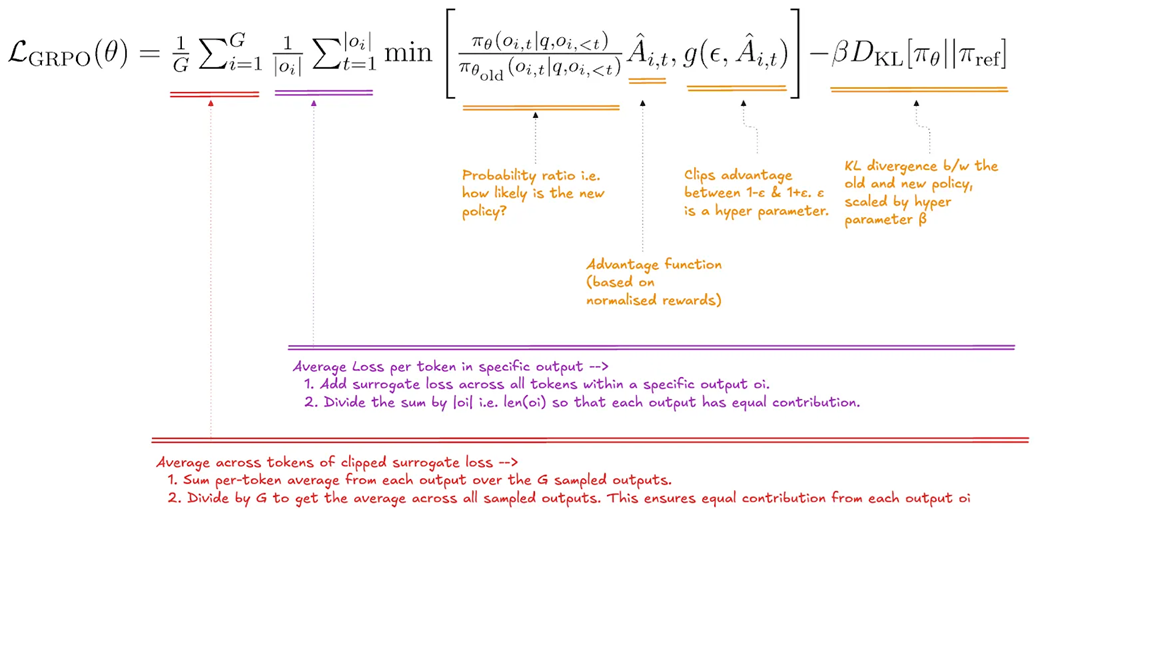

In [ ]:
#RLHF CODE - GET THE BASICS RIGHT
#dataset roneneldan/TinyStories
!git clone https://github.com/karpathy/mingpt.git
%cd mingpt
!pip install .
!pip install nltk


In [ ]:
import copy , os , datasets , torch , nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import sys
!pip install mingpt

from mingpt import model
from mingpt.model import GPT
#from mingpt.char_tokenizer import CharTokenizer
from mingpt.logger import Logger
from mingpt.trainer import Trainer
from mingpt.utils import set_seed

In [ ]:
import copy , os , datasets , torch , nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

import sys
from mingpt.model import GPT
#from mingpt.char_tokenizer import CharTokenizer
#from mingpt.logger import Logger
#from mingpt.trainer import Trainer
from mingpt.utils import set_seed

class CharTokenizer():
  pad_char = "-"
  eot_char = "⏎"

  def __init__(self,data):
    chars = sorted(list(set(data) | {self.pad_char, self.eot_char})) # creating vocab of all unique characters
    data_size , vocab_size = len(data) , len(chars)
    print("data has %d characters , %d unique" % (data_size,vocab_size))
    self.stoi = {ch:i for i,ch in enumerate(chars)} #string to integer
    self.itos = {i:ch for i,ch in enumerate(chars)} #integer to string
    self.vocab_size = vocab_size
    self.pad_token = self.stoi[self.pad_char]
    self.eot_token = self.stoi[self.eot_char]

  def __call__(self, text:str) ->torch.LongTensor:
    # Corrected the way of creating a LongTensor from a list
    return torch.tensor([self.stoi[c] for c in text if c in self.stoi], dtype=torch.long)
  def decode(self, tokens ,ignore_padding = False) ->str:
    return "".join([self.itos[i] for i in tokens.tolist() if i in self.itos and not ignore_padding or i != self.pad_token])

In [ ]:
# Re-import the Trainer class from the modified file
class StoryDataset(Dataset):
  """TinyStories Dataset https://huggingface.co/datasets/roneneldan/TinyStories"""

  def __init__(self,block_size, split="train",filter_sentiment= None , tokenizer = None):
    super().__init__()
    self.block_size = block_size
    self.split = split
    self.filter_sentiment = filter_sentiment
    self.tokenizer = tokenizer
    eot_char = "⏎"

    #helper function to process and chunk the text examples
    def chunk_examples(examples):
      chunks = [(eot_char+text+eot_char) for text in examples['text'] if len(text)>0]
      return {"content":chunks}
      print(f"Loading TinyStories dataset for split:{split}")
    dataset = datasets.load_dataset("roneneldan/TinyStories",split = split)

    #filter the dataset for by sentiment for SFT
    if filter_sentiment:
      sid = SentimentIntensityAnalyzer()
      def is_positive(example):
        return sid.polarity_scores(example['text'])['compound'] > 0.5
      if filter_sentiment == "positive":
        dataset = dataset.filter(is_positive)
      else:
        pass
    self.dataset = dataset.map(chunk_examples , batched= True , remove_columns = dataset.column_names)

    #intialize tokenizer
    if self.tokenizer is None:
      print("Building a new tokenizer")
      token_text_example = "".join(row["content"] for row in self.dataset.select(range(10000)))
      self.tokenizer = CharTokenizer(token_text_example)
      print("Tokenizer built")

  def get_vocab_size(self):
    return self.tokenizer.vocab_size
  def get_block_size(self):
    return self.block_size
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self,idx):
    chunk = self.dataset[idx]["content"]
    tokens = self.tokenizer(chunk)
    assert(len(tokens)) >0
    if len(tokens) >=self.block_size +1:
      tokens = tokens[:self.block_size+1]
    else:
      pad = torch.full((self.block_size+1,),self.tokenizer.pad_token , dtype = torch.long)
      pad[:len(tokens)] = tokens # Use 'tokens' instead of 'toks'
      tokens = pad
    x = tokens[:-1]
    y = tokens[1:].clone() #creating target label sequence by shifting the intial sequence by 1
    y[y==self.tokenizer.pad_token] = -1 # masks padding in the target

    #our mask is true for padding / unused tasks
    #to match the causal masking inside the miniGPT model
    attn_mask = x ==self.tokenizer.pad_token #attention should not be paid to pad_token
    return x, y ,attn_mask #returns input , output and attn_mask

class SentimentRewardModel(): #verifiable reward as we are using a tool to give rewards.
  def __init__(self,tokenizer):
    self.tokenizer = tokenizer
    self.sid = SentimentIntensityAnalyzer()
  def sentiment(self,sentence:str) ->float:
    #retun a "compound" score which is normalized , weighted composite sentiment score
    return self.sid.polarity_scores(sentence)['compound']
  def __call__(self,tokens):
    bs = tokens.shape[0]
    rewards = torch.zeros(bs)
    for i in range(bs):
      #decode the tokens back into a sequence
      sentence = self.tokenizer.decode(tokens[i])
      #calculate the sentiment score for the decoded sentence
      rewards[i] = self.sentiment(sentence)
    return rewards.to(tokens.device)

def batch_end_callback(trainer):
  model = trainer.model
  model.eval()
  # Log training loss
  trainer.logger.log("Train", trainer.iter_num, trainer.loss.item())

  if trainer.iter_num % trainer.config.log_every == 0:
    with torch.no_grad():
      total_loss = 0
      for i , batch in enumerate(valid_loader):
        x,y, mask = [x.to(trainer.device) for x in batch]
        logits , loss = model(x,y,attention_mask = mask)
        total_loss +=loss.item()

    val_loss = total_loss/(i+1)
    trainer.logger.log("Valid", trainer.iter_num, val_loss)
    print(f"Epoch: {trainer.epoch}, Iteration: {trainer.iter_num}, Train Loss: {trainer.loss.item():.5f}, Validation Loss: {val_loss:.5f}")

  if trainer.iter_num % trainer.config.generate_every == 0:
    with torch.no_grad():
      context = train_ds.tokenizer(TEST_PROMPT)[None]
      x = context.to(trainer.device)
      y = model.generate(x,140,temperature = 1.0 , do_sample= True,top_k=20)[0]
      completion = train_ds.tokenizer.decode(y)
  model.train()

if __name__ == '__main__':
  set_seed(42)
  TEST_PROMPT =  "⏎Once upon a time, "
  block_size = 64
  print("===== STARTING PRETRAINING on TinyStories =====") #POLICY MODEL
  #intialize datasets
  train_ds = StoryDataset(block_size , split = "train")
  valid_ds = StoryDataset(block_size , split = "validation",tokenizer = train_ds.tokenizer)
  end_of_text = train_ds.tokenizer.eot_token

  #model configuration
  model_config = GPT.get_default_config()
  model_config.model_type = "gpt-micro"
  model_config.vocab_size = train_ds.get_vocab_size()
  model_config.block_size = block_size
  model = GPT(model_config)


  # Trainer Configuration
  train_config = Trainer.get_default_config()
  train_config.learning_rate = 5e-4 # Slightly adjusted learning rate
  train_config.num_workers = 4 # Use more workers if your machine supports it
  train_config.log_every = 2000
  train_config.generate_every = 5000
  # TinyStories is huge, so 1 epoch is already a lot of training
  train_config.epochs = 1
  train_config.compile = True # Use torch.compile for a speedup if available
  train_config.batch_size = 128 # Increase batch size if GPU memory allows

  trainer = Trainer(train_config, model, train_ds)
  device = trainer.device

  valid_loader = DataLoader(
      valid_ds,
      shuffle=False,
      batch_size=trainer.config.batch_size*2,
      num_workers=train_config.num_workers
  )
  trainer.set_callback("on_batch_end", batch_end_callback)
  trainer.run()
  print("\n===== DONE PRETRAINING =====")

  # Save the pretrained model
  print("\n===== SAVING PRETRAINED MODEL =====")
  pretrained_ckpt_path = os.path.join(os.path.curdir, "story_gpt_pretrained.pt")
  torch.save(model.state_dict(), pretrained_ckpt_path)
  print("\n===== DONE SAVING =====")

  #generate a sample after pretraining
  sample_prompt = torch.full((3,1),end_of_text,dtype = torch.long,device = device)
  idx = model.generate(sample_prompt, max_new_tokens = 80,top_k=30, do_sample = True)
  for j , generation in enumerate(idx):
    print(f"Pre Trained Generation {j+1}:", train_ds.tokenizer.decode(generation))


  print("\n===== STARTING SUPERVISED FINE-TUNING (SFT) =====")
  # of the POLICY model - so for RLHF - combo being used is -> Policy Model + SFT (rationale is this SFT steps imporves the accuray of model)
  sft_dataset = StoryDataset(block_size, split="train", filter_sentiment="positive", tokenizer=train_ds.tokenizer)
  sft_valid = StoryDataset(block_size, split="validation", filter_sentiment="positive", tokenizer=train_ds.tokenizer)
  sft_loader = DataLoader(
      sft_dataset,
      shuffle=True,
      batch_size=train_config.batch_size,
      num_workers=train_config.num_workers,
  )
  #adjust the training config for fine tuning for base   model = GPT(model_config)
  train_config.learning_rate = 1e-4 # lower learning rate for fine tuning
  train_config.epochs = 2 # only two epochs

  trainer = Trainer(train_config, model, sft_loader)
  trainer.set_callback("on_batch_end", batch_end_callback)
  trainer.run()
  print("\n===== DONE SFT =====")

  #check generation from SFT model
  idx = model.generate(sample_prompt, max_new_tokens = 80,top_k=30, do_sample = True)
  for j , generation in enumerate(idx):
    print(f"SFT Generation {j+1}:", train_ds.tokenizer.decode(generation))

  print("\n===== STARTING RL IN-CONTEXT LEARNING (ICL) =====")
  #reward model here is Sentiment Score of the story from the story dataset
  #so it is RLVR = Policy Model(Pre-Trained) + Policy Model(SFT) + Using Reward Model (in this case using Positive Reward Analyzer as reward model)..
  #.. to train the model on human preferences
  ref_model = copy.deepcopy(model) #original mini-gpt model
  ref_model.requires_grad(False) #why as we want the policy model weights to not change
  ref_model.eval()

  #reward model
  reward_model = SentimentRewardModel(train_ds.tokenizer)
  #RL paramaters
  batch_size = 64
  num_iters = 200
  learning_rate = 1e-5
  grad_norm_clip = 1.0
  kl_beta = 0.1 # kl divergence coeff

  model.to(device)
  logger = Logger()
  optimizer  = torch.optim.Adam(model.parameters(),lr = learning_rate, betas=(0.9,0.95))
  prompt = torch.full((batch_size,1),end_of_text,dtype = torch.long,device = device)

  print("Starting RL training loop...")
  for i in range(num_iters):
    with torch.nograd(): #don't train the model
      model.eval()
      completion = model.generate(prompt,140,temperature = 1.0 , do_sample= True,top_k=30) #sampling trajectories
      model.train()
      rewards = reward_model(completion) # we want the policy mode
      ref_log_probs = ref_model.log_probs(completion[:,:1], completion[:,1:])

    log_probs = model.log_probs(completion[:,:1], completion[:,1:]) #log probs of at/st (action given state) from trajectories
    kl = log_probs - ref_log_probs # take KL divergence between the Policy Model (min-gpt pretrained on tinystories) + Ref Model(min-gpt)
    # the score is a combination of the reward and KL penalty to prevent the model from deviating too far from the reference
    score = - kl_beta*kl
    score += rewards[:,None]
    score.detach()

    #vanilla policy gradient loss
    pg_loss = -torch.mean(score*log_probs)
    #torch.mean = summation of (sampling from i.n samples and then taking t=0 .. t=T trajectories . reward score and log probs is log_probs of at/st policy model)
    loss = pg_loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
    optimizer.step()
    optimizer.zero_grad()

    if i %50 ==0:
      model.eval()
      idx = model.generate(prompt,140,temperature = 1.0 , do_sample= True,top_k=30).cpu()
      for j , generation in enumerate(idx):
        print(f"RL Generation {j+1}:", train_ds.tokenizer.decode(generation))
      model.train()
  print("RL DONE")

  idx = model.generate(sample_prompt, max_new_tokens = 80,top_k=30, do_sample = True)
  for j , generation in enumerate(idx):
    print(f"RL Generation {j+1}:", train_ds.tokenizer.decode(generation))

In [ ]:
#reward model loss function call
import torch
import torch.nn as nn
from torch.nn import functional as F

class RewardModel(nn.Module): #define the nn for reward model
  def __init__(self):
    super.__init__()
  def forward(self,r_chosen,r_rejected):
    #forward pass for calculating the scalar value of reward
    #input is  a tensor of size [B] -batch_size
    delta = r_chosen - r_rejected #shape of tensor [B]
    loss = -F.logsigmoid(delta).mean
    return loss
#training loop
model = RewardModel()
r_chosen = model(prompt, chosen) #shape[B,T]
r_rejected = model(prompt, rejected) #shape[B,T]

#backward pass
loss.backward() #torch calculates gradients and update gradients for both chosen and rejected rewards in one go ...
optimizer.step()
optimizer.zero_grad()

In [ ]:
#openrlhf code for training a RLHF model
import wandb
wandb.login(key = "b281e20d5ef0492c9dc7371d0ccf59fd8dfeb619")


In [ ]:
!pip install --upgrade datasets
!pip install openrlhf
!pip install openrlhf[vllm]

In [ ]:
from datasets import load_dataset
import os
N_TRAIN = 1600
N_TEST = 160
SEED = 42

#load and shuffle the test
full = load_dataset("OpenRLHF/prompt-collection-v0.1", split = "train")
full = full.shuffle(seed = SEED)

train_dataset = full.select(range(N_TRAIN))
test_dataset = full.select(range(N_TEST))
#save to disk
train_dataset.save_to_disk("train")
test_dataset.save_to_disk("test")
print(f"Saved {len(train_dataset)} train examples")
print(f"Saved {len(test_dataset)} test examples")

In [ ]:
from datasets import load_from_disk
#load dataset from disk
train_dataset_path = "/content/train"
train_dataset = load_from_disk(train_dataset_path)

#select and display an example prompt
#dataset is in a col format / parquet file and we need to accesss that direclty with a subscript....
#what dataset object returns is a array
if len(train_dataset)>0:
  example_prompt = train_dataset[2]
  print("Example Prompt",example_prompt)
else:
  print("the training dataset is empty")

In [ ]:
"""
#train the SFT / Ref model on this dataset
#PPO trainig requires four models
1. Reward Model (Trained on chosen and rejected . not trained using PPO)
2. Policy Model(SFT trained and then using PPO )
3. Ref Model (not trained during PPO):(intialized from SFT model)
4. Value Model(Critic Model - initialized using the reward model)
Initially two models need to be prepared
1.Reward Model
2.Actor Model
The Actor Model is HuggingFaceTB/SmolLM2-135M-Instruct Model and this is SFT
Reward model is AI-Roadmap/SmolLM2-135M-rm-60k / AI-Roadmap/SmolLM2-135M-rm-60k
"""
!pip uninstall -y flash-attn

In [ ]:
pip cache purge

In [ ]:
pip install flash-attn --no-cache-dir

In [ ]:
#check the performance of HuggingFaceTB/SmolLM2-135M-Instruct Model based on  AI-Roadmap/SmolLM2-135M-rm-60k model how ?
import torch
from datasets import load_from_disk
from transformers import AutoTokenizer
from openrlhf.models import get_llm_for_sequence_regression  # get a transformer model and use a linear regression layer to get a value .... Ideal for reward model
from vllm import LLM , SamplingParams
from vllm.engine.llm_engine import LLMEngine
from tqdm.notebook import tqdm

def evaluate_model_vllm(test_dataset_path,rm_model,lm_model, seed = 42,max_new_tokens = 1024):
  #load the data from disk
  ds = load_from_disk(test_dataset_path)
  raw_prompts = ds["context_messages"]
  num_samples = len(raw_prompts)

  #prepare reward-model components
  rm_tokenizer = AutoTokenizer.from_pretrained(rm_model)
  rm_model = get_llm_for_sequence_regression(
      model_name_or_path = rm_model,
      model_type = "reward",
      bf16 = True, # mixed precision
      init_value_head = False,
      )
  rm_model.eval()
  rm_model.to("cuda")

  #prepare vllm for generation
  lm_tokenizer = AutoTokenizer.from_pretrained(lm_model)
  formatted_prompts = []
  for prompt in raw_prompts:
    #apply the same chat template as used before
    prompt_text = lm_tokenizer.apply_chat_template(prompt, tokenize = False, add_generation_prompt = True)
    formatted_prompts.append(prompt_text)

  #sampling settings
  sampling_params = SamplingParams(
      max_tokens = max_new_tokens,
      min_tokens =1,
      temperature = 1.0,
      top_p = 1.0,
      top_k = 1,
      seed = seed,
      skip_special_tokens = False,
      include_stop_str_in_output = True,
  )

  #run batched inference
  llm_engine = LLM(lm_model)
  outputs = llm_engine.generate(formatted_prompts, sampling_params, use_tqdm = True)
  llm_engine.sleep(level=2) #discards both the model weights and KV Cache # release the GPU memory

  total_reward = 0.0
  total_length = 0
  evaluation_results = []

  progressBar = tqdm(total = num_samples, desc ="Evaluate Rewards")
  #iterate through vLLM outputs in the same order as your prompts
  for i in output in enumerate(outputs):
    raw_prompt = raw_prompts[i]
    prompt = rm_tokenizer.apply_chat_template(raw_prompt , tokenize = False , add_genration_prompt = True)
    response = output.outputs[0].text

    rm_input = prompt + response

    #score with reward model
    rm_input = rm_tokenizer(rm_input, return_tensors = "pt", truncation = True , padding = True).to(rm_model.device)
    with torch.inference_mode():
      reward_score = rm_model(**rm_input)
    reward_score = float(reward_score)
    total_reward +=reward_score

    response_ids = rm_tokenizer(response,return_tensors = "pt",truncation = True , padding = True).to(rm_model.device)
    total_length += response_ids['input_ids'].shape[1]
  progressBar.close()
  avg_reward = total_reward/num_samples
  avg_length = total_length/num_samples
  print(f"Samples Evaluated: {num_samples}")
  print(f"Average Reward: {avg_reward}")
  print(f"Average Length: {avg_length}")
  return evaluation_results

In [ ]:
evalution_results = evaluate_model_vllm("/content/test",rm_model="AI-Roadmap/SmolLM2-135M-rm-60k",lm_model="HuggingFaceTB/SmolLM2-135M-Instruct",max_new_tokens = 1024)

In [ ]:
#check for distributon of rewards... so basically you have reward model giving reward to the generated text of another model as a starting point
#this is for SFT trained model  and acts as a base....

#so basically Instruction Tuned SFT models are further fine tuned using RLHF and average reward of both models can be compared. Reward distribution. OpenRLHF can be used for train Policy Model

In [ ]:
#training by open RLHF
import os , json ,subprocess , re
import matplotlib.pyplot as plt

#wandb project
WANDB_Project = "openrlhf-test"
working_dir = "openrlhf"
os.makedirs(working_dir,exist_ok = True)
runtime_env_json = json.dumps(runtime_env)
try:
  subprocess.run(["ray","start","==head","==node-ip.address","0.0.0.0","==num_gpus","1"], check = True)
except:subprocess.CalledProcessError

submit_ray_job_command = []
submit_ray_job_command.append("ray")
submit_ray_job_command.append("submit")
submit_ray_job_command.append("--address")
submit_ray_job_command.append("ray://localhost:10001")

#we se ray and can specify no of GPUs to use as Ray is for distrubuted training  and .... another imp config param is -micro_rollout_batch_size ="8" -> means 8 sequences processed parallely
#roll out means how many sequences are we processing parallely
#use apply chat template can be used
#

In [ ]:
#code for GRPO
#key is that reward is calculated for each generated response and rewards are averaged at group level and then advantage is calculated considering this avg reward...
#this is key and it leads to faster training and serving of GRPO models on limited hardware
#train Qwen on GSM8K
%%capture
!pip install unsloth vllm
!pip install --update pillow

!pip install git+https://github.com/huggingface/trl.git@e95f9fb74a3c3647b86f251b7e230ec51c64b72b #trl for using GRPO



In [ ]:
from unsloth import FastLanguageModel , PatchFastRL
#execute the patch
PatchFastRL("GRPO", FastLanguageModel)

In [ ]:
import torch
#load base model and tokenizer
model , tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen2.5-7B-Instruct",
    max_seq_length = 2048,
    load_in_4bit = True,
    fast_inference = True, #enable vLLm for fast inference
    max_lora_rank= 64, #Larger rank = smarter , but slower
    gpu_memory_utilization = 0.9, # reduce if OOM
    torch_dtype = torch.bfloat16, #computation will happen in dtype .... even though model is loaded in 4 bit....
)

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=64,
    target_modules= [
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "u_proj",
        "down_proj"
    ],
    lora_alpha = 64,
    use_gradient_checkpointing = "unsloth",
    lora_dropout = 0.05,
    bias = "none",
    # Removed redundant task_type argument
    random_state = 3047
)

In [ ]:
#model loaded now prepare for dataset
import re
from datasets import load_dataset , Dataset
#load and prep dataset
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

#helper function for parsing Answer
def extract_hash_answer(text:str) ->str|None:
  if "###" not in text:
    return None
  return text.split("###")[1].strip()

#uncomment middle messages for 1-shot prompting
def get_gsm8k_questions(split="train") ->Dataset:
  gsm8k = load_dataset("openai/gsm8k","main",split = split)
  gsm8k = gsm8k.map(lambda x:{
      'prompt':[
          {'role':'system','content':SYSTEM_PROMPT},
          {'role':'user','content':x['question']},
          ],
          'answer':extract_hash_answer(x['answer'])
  })
  return gsm8k
dataset = get_gsm8k_questions()

In [ ]:
#define reward function
def extract_xml_answer(text:str) ->str:
  answer = text.split("<answer>")[-1]
  answer = answer.split("</answer>")[0]
  return answer.strip()

def correctness_reward_func(prompts,completions,answer,**kwargs) ->list[float]:
  responses = [completion[0]['content'] for completion in completions]
  q = prompts[0][-1]['content']
  extracted_responses = [extract_xml_answer(r) for r in responses]
  print('-'*20,f"Question:\n{q}",f"\nAnswer:\n{answer[0]}",f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
  return [2.0 if r==a else 0.0 for r,a in zip(extracted_responses,answer)]

In [ ]:
def int_reward_func(completions,**kwargs) ->list[float]:
  responses = [completion[0]['content'] for completion in completions]
  extracted_responses = [extract_xml_answer(r) for r in responses]
  return[0.5 if r.isdigit() else 0.0 for r in extracted_responses]

In [ ]:
def strict_format_reward_func(completions, **kwargs) -> list[float]:
  """ Reward function that checks if the completion has a specific format."""
  pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>$"
  responses = [completion[0]['content'] for completion in completions]
  matches = [re.match(pattern,r) for r in responses]
  return[0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
  """ Reward function that checks if the completion has a specific format."""
  pattern = r"^<reasoning>.*?</reasoning>\s*<answer>.*?</answer>$"
  responses = [completion[0]['content'] for completion in completions]
  matches = [re.match(pattern,r) for r in responses]
  return[0.5 if match else 0.0 for match in matches]

#XML counting helper function
def count_xml(text) -> float:
  count = 0.0
  if text.count("<reasoning>\n") ==1:
      count+=0.125
  if text.count("\n<reasoning>\n") ==1:
      count+=0.125
  if text.count("\n<answer>\n") ==1:
      count+=0.125
      count -= len(text.split("\n</answer>\n")[-1])*0.001
  if text.count("\n</answer>") ==1:
        count+=0.125
        count -= len(text.split("\n</answer>")[-1] -1)*0.001
  return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
  responses = [completion[0]['content'] for completion in completions]
  return[count_xml(r) for r in responses]

In [ ]:
#training the model
from trl import GRPOConfig , GRPOTrainer
from unsloth import is_bfloat16_supported

#defining trainer arguments
training_args = GRPOConfig(
    use_vllm = True,
    learning_rate = 5e-6, #smaller learning rate for stable training
    adam_beta1 = 0.9, #AdamW first momentum
    adam_beta2 = 0.99, #Adwm second momentum
    weight_decay = 0.1, #L2 regularization to prevent overfitting
    warmup_ratio = 0.1, #portion of training steps for learning rate warmup
    lr_scheduler_type ="cosine", #learning rate decay
    optim ="adamw_8bit", #use 8 bit adam w bit optimizer for memory efficiency
    logging_steps =1,
    bf16 = is_bfloat16_supported(), #use bfloat16 if hardware supports it
    fp16 = not is_bfloat16_supported(), #fallback to float16 if bfloat16 is not supported
    per_device_train_batch_size = 1, # no of prompts per GPU - EBS
    gradient_accumulation_steps = 1, # number of steps to accumlate gradients
    num_generations = 8, #(G) no of responses to be generated per prompt for GRPO
    max_prompt_length = 256, # max length of input prompts in tokens
    #--------------------> key is that seq_length = max_prompt_length(prompt ref region) + max_completion_length
    #goes into GPU and memory is defined at this.... max_prompt_length is used for reference and
    #KL diveregence calculated by Ref Model... Policy Model shouldn't deviate from this....
    #max_completion_length is where reward model is applied
    #-------------------->
    max_completion_length = 512, #max length of model responses in tokens
    max_steps = 2000, #total number of training steps
    save_steps = 250, # save checkpoint after 250 steps
    max_grad_norm = 0.1, #Gradient clipping threshold
    report_to  = "wandb",
    output_dir = "outputs"
)


In [ ]:
#create the trainer
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        xmlcount_reward_func,
        int_reward_func,
        strict_format_reward_func,
        soft_format_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)

In [ ]:
trainer.train()

In [ ]:
#save the LoRA adapter
model.save_lora("grpo_saved_lora")

#merge to 16bit  -replace with your HF Repo, Model Name, and HF Token
if True: model.save_pretrained_merged("model",tokenizer,save_method="merged_16bit")
if True: model.save_pretrained_merged("hf/model",tokenizer,save_method="merged_16bit", token="")


In [ ]:
%%capture
!pip install unsloth vllm
!pip install --upgrade pillow

In [ ]:
from unsloth import FastLanguageModel
from vllm import LLM , SamplingParams
from vllm.engine.llm_engine import LLMEngine

#Load the Model and Tokenizer
model , tokenizer = FastLanguageModel.from_pretrained(
    model_name =
)

In [ ]:
#fine tuning Qwen Model on thinking
#install dependencies
!pip install --no-deps bitsandbytes accelerate xformers peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth
!pip install vllm

In [ ]:
from unsloth import FastLanguageModel
import torch
#load the base model and tokenizer
model , tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-14B",
    max_seq_length = 2048,
    load_in_4bit = True,
    fast_inference = True,
    max_lora_rank = 64,
    gpu_memory_utilization = 0.9,
)
#Add LoRA Adapters to the model
model = FastLanguageModel.get_peft_model(
    model,
    r=32, #LoRA rank (higher rank = more parameters , potentially better fit but more memory)
    target_modules = [
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "u_proj",
        "down_proj"
    ],
    lora_alpha = 32, #scaling factor for updating LoRA Adapter Weight Parameters (often set to r to 2r)
    lora_dropout = 0, #drop probability for LoRA layers
    bias = "none", #Fine-tuning bias terms ('none' is often optimal)
    use_gradient_checkpointing = "unsloth", #use this for memory savings
    random_state = 3047,
    use_rslora = False, # Rank Stable LoRA(optional)
    loftq_config = None, # LoftQ intialization (optional)
)

In [ ]:
from datasets import load_dataset
reasoning_dataset = load_dataset("unsloth/OpenMathReasoning-mini",split = "cot")
non_reasoning_dataset = load_dataset("mlabonne/FineTome-100k",split = "train")
print("Reasoning Dataset",reasoning_dataset[0])
print("\n Non-Reasoning Dataset Example row (raw)",non_reasoning_dataset[0])


In [ ]:
def generate_reasoning_conversation(examples):
  problems = examples["problem"]
  # the 'generated solution ' contains the COT-Reasoning
  solutions = examples["generated_solutions"]
  conversations = []
  for problem , solution in zip(problems , solutions):
    conversations.append([
        {"role":"user", "content":problem},
        {"role":"assistant","content":solution},
    ])
  return {"conversations":conversations}
#apply the chat template (without tokenizing yet)
#the generated_solution in the dataset ALREADY contains the <think> tags properly formatted
reasoning_formatted_texts = tokenizer.apply_chat_template(
    reasoning_dataset.map(generate_reasoning_conversation,batched = True)["conversations"],
    tokenize = False,
)

In [ ]:
from unsloth.chat_templates import standardize_sharegpt # share gpt format data for conversations
#non reasoning based data that has no <THINK> </THINK> tag
#standardize
standardized_non_reasoning_dataset = standardize_sharegpt(non_reasoning_dataset)
#apply the chat template
non_reasoning_formatted_texts = tokenizer.apply_chat_template(
    standardized_non_reasoning_dataset["conversations"],
    tokenize = False,
)
print("\n First formatted Non-Reasoning Row")
print(non_reasoning_formatted_texts[0])

In [ ]:
#combine the datsets - thinking and non-thinking
import pandas as pd
from datasets import Dataset
#define chat data percentage
chat_percentage = 0.75
reasoning_series = pd.Series(reasoning_formatted_texts)
non_reasoning_series = pd.Series(non_reasoning_formatted_texts)

#number of non reasoning samples we need
num_non_reasoning_samples = int(len(reasoning_series) * (chat_percentage/(1.0 - chat_percentage)))
num_non_reasoning_samples = min(num_non_reasoning_samples,len(non_reasoning_series))

print(f"Using {len(reasoning_series)} reasoning_samples")
print(f"Using {num_non_reasoning_samples} non-reasoning samples")
non_reasoning_subset = non_reasoning_series.sample(n = num_non_reasoning_samples,random_state = 3047)

#combine the dataset
combined_series = pd.concat([reasoning_series,non_reasoning_subset])
combined_series.name = "text" #SFT Trainer expects this column name ?

#convert back to Hugging Face Dataset and Shuffle
combined_dataset = Dataset.from_pandas(combined_series.to_frame()).shuffle(seed = 3047)

print(f"\n Final Combined Dataset size:{len(combined_dataset)}")
print("Example entry from combined dataset")
print(combined_dataset[0]['text'])

In [ ]:
#code for training the model
from trl import SFTTrainer , SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = combined_dataset,
    dataset_text_field = "text",
    max_seq_length = 2048, #should match model loading
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4, #EBS = 2*4 = 8
        learning_rate = 2e-5,
        bf16 = True,
        logging_steps = 1,
        learning_rate = 2e-5,
        bf16 = True,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs", #directory to save checkpoints
        report_to = "none"
    ),
)
#Start Training
print("Starting Training...")
trainer_stats = trainer.train()
print("Training Complete...")

In [ ]:
#INFERENCE
#NON-THINKING
from transformers import TextStreamer
messages =[
    {"role":"user","content":"Solve(x+2)^2 =0."}
]
text_input_no_think = tokenizer.apply_chat_template(messages,tokenize = False,add_generation_prompt = True,enable_thinking = False)
print("---Non Thinking Inference---")
print("Formatted Input:\n",text_input_no_think)
#Generate response using paramaters suitable for non-thinking/chat
inputs = tokenizer(text_input_no_think,return_tensors = "pt").to("cuda")
streamer_no_think = TextStreamer(tokenizer, skip_prompt = True)
_= model.generate(**inputs,
                  streamer = streamer_no_think,
                  max_new_tokens = 256,
                  temperature = 0.7,
                  top_p = 0.8,
                  top_k = 20,
                  eos_token_id = tokenizer.eos_token_id)
print("\n-----------------------------")

In [ ]:
#INFERENCE
#THINKING
text_input_think = tokenizer.apply_chat_template(messages,tokenize = False,add_generation_prompt = True,enable_thinking = True)
print("--- Thinking Inference---")
print("Formatted Input:\n",text_input_think)
#Generate response using paramaters suitable for non-thinking/chat
inputs_think = tokenizer(text_input_think,return_tensors = "pt").to("cuda")
streamer_think = TextStreamer(tokenizer, skip_prompt = True)
_= model.generate(**inputs_think,
                  streamer = streamer_no_think,
                  max_new_tokens = 256,
                  temperature = 0.7,
                  top_p = 0.8,
                  top_k = 20,
                  eos_token_id = tokenizer.eos_token_id)
print("\n-----------------------------")

In [ ]:
#save the model
#save LoRA adapters locally
model.save_pretrained("qwen3_14b_reasoning_chat_lora")
tokenizer.save_pretrained("qwen3_14b_reasoning_chat_lora") # save tokenizer also this is KEY
#Optional push to hub
#model.push_to_hub("user_name/qwen3_14b_reasoning_chat_lora, token = HF_TOKEN")
#tokenizer.push_to_hub("user_name/qwen3_14b_reasoning_chat_lora, token = HF_TOKEN")

#To load these adapters later:
#model , tokenizer = FastLanguageModel.from_pretrained(model_name = "user_name/qwen3_14b_reasoning_chat_lora" , load_in_4bit = True)

In [ ]:
%%capture
!pip install --upgrade --force-reinstall --no-cache-dir --no-deps unsloth unsloth_zoo
!pip install torch
!pip install vllm
!pip install xformers
!pip install xgrammar
!pip install --force--reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unssloth.git
!pip install trl

In [ ]:
!pip install bitsandbytes
from unsloth import FastLanguageModel
import bitsandbytes as bnb
import torch

max_sequence_length = 2048
dtype = None
load_in_4bit = True

model , tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/DeepSeek-R1-Distill-Llama-8B",
    max_seq_length = max_sequence_length,
    load_in_4bit = load_in_4bit,
    fast_inference = True
)

In [ ]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(tokenizer,chat_template = "llama-3.2")
tokenizer.pad_token = tokenizer.eos_token
FastLanguageModel.for_inference(model)

messages = [{"role":"user", "content":"I am very happy as I have cracked Alberson offer today and Blend 360 offer today"}]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True,
    enable_thinking = True,
    return_tensors = "pt",
    padding = True,
    truncation = True,
    max_length = 2048
).to("cuda")

attention_mask = inputs !=tokenizer.pad_token_id

outputs = model.generate(
    input_ids = inputs,
    attention_mask = attention_mask,
    max_new_tokens = 256,
    use_cache = True,
    temperature = 0.6,
    min_p = 0.1
)
text = tokenizer.decode(outputs[0],skip_special_tokens = True)
print(text)

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules = [
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "u_proj",
        "down_proj"
    ],
    bias= "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    lora_alpha = 16,
    lora_dropout = 0,
    use_rslora = False,
    loftq_config = None,
)


In [ ]:
#load data
from datasets import load_dataset
#load dataset
dataset = load_dataset("Sulav/mental_health_counseling_conversations_sharegpt",split = "train")

In [ ]:
import unsloth
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.2"
)
def formatting_prompts_func(examples):
  convos = examples["conversations"]
  texts = [tokenizer.apply_chat_template(convo,tokenize= False , add_generation_prompt =False) for convo in convos]
  return{"text":texts}
dataset = dataset.map(formatting_prompts_func,batched=True)
print(dataset[0]["conversations"])
print(dataset[0]["text"])

In [ ]:
#start model training
from trl import SFTTrainer , SFTConfig
from transformers import TrainingArguments , DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

#defining training configuration
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = 2048,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer,padding = True),
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2, #number of examples per GPU batch
        gradient_accumulation_steps = 4, #EBS = 2*4 = 8
        warmup_steps = 5, #number of warmup steps
        max_steps =0,
        learning_rate = 2e-4,
        num_train_epochs = 1,
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        output_dir = "outputs",
        report_to = "wandb",
        optim = "adamw_8bit",
        lr_scheduler_type = "cosine",
        save_strategy = "epoch",
        ),
)




In [ ]:
from trl import SFTTrainer , SFTConfig
from transformers import TrainingArguments , DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

# Custom formatting function to apply train_on_responses_only logic
def custom_formatting_func(examples):
    # Tokenize the text field
    # We expect examples["text"] to be a list of strings
    tokenized_inputs = tokenizer(
        examples["text"],
        padding="max_length", # Or 'longest' if DataCollator handles it
        truncation=True,
        max_length=2048, # Ensure this matches the model's max_seq_length
        return_tensors="pt"
    )

    input_ids = tokenized_inputs["input_ids"]
    attention_mask = tokenized_inputs["attention_mask"]
    labels = input_ids.clone()

    # Define the start sequence for the assistant's response
    # This should match the chat template's structure for an assistant's turn
    response_start_string = "<|start_header_id|>assistant<|end_header_id|>\n\n"
    response_start_tokens_ids = tokenizer.encode(
        response_start_string,
        add_special_tokens=False,
        return_tensors="pt"
    ).squeeze(0) # Get as a 1D tensor of token IDs

    # Apply masking logic
    for i in range(labels.shape[0]): # Iterate over each example in the batch
        current_input_ids = input_ids[i]

        # Find the index where the assistant's response starts
        # Convert tensor to list for simple sequence search
        current_input_ids_list = current_input_ids.tolist()
        response_start_tokens_list = response_start_tokens_ids.tolist()

        start_index = -1
        for j in range(len(current_input_ids_list) - len(response_start_tokens_list) + 1):
            if current_input_ids_list[j:j + len(response_start_tokens_list)] == response_start_tokens_list:
                start_index = j + len(response_start_tokens_list)
                break

        if start_index != -1:
            # Mask out tokens before the assistant's response
            labels[i, :start_index] = -100
        else:
            # If assistant's response start marker not found, mask all tokens for this example
            # This indicates an issue with the template or data
            labels[i, :] = -100

        # Mask padding tokens in labels
        labels[i, labels[i] == tokenizer.pad_token_id] = -100

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels, # Return as a tensor
    }

#defining training configuration
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    formatting_func = custom_formatting_func, # Use the custom formatting function
    # dataset_text_field = "text", # When using formatting_func, dataset_text_field is not used for tokenization
    max_seq_length = 2048,
    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True), # Data collator for sequence to sequence tasks
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2, #number of examples per GPU batch
        gradient_accumulation_steps = 4, #EBS = 2*4 = 8
        warmup_steps = 5, #number of warmup steps
        max_steps =0,
        learning_rate = 2e-4,
        num_train_epochs = 1,
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        output_dir = "outputs",
        report_to = "wandb",
        optim = "adamw_8bit",
        lr_scheduler_type = "cosine",
        save_strategy = "epoch",
        ),
)

# Start training
trainer_stats = trainer.train()


In [ ]:
#inference
tokenizer = get_chat_template(tokenizer,chat_template = "llama-3.2")
tokenizer.pad_token = tokenizer.eos_token
FastLanguageModel.for_inference(model)
messages = [{"role":"user", "content":"I am mentally very strong"}]
inputs = tokenizer.apply_chat_template(messages,tokenize = True,add_generation_prompt = True,enable_thinking = True,return_tensors = "pt").to("cuda")
attention_mask = inputs !=tokenizer.pad_token_id
outputs = model.generate(
    input_ids = inputs,
    attention_mask = attention_mask,
    max_new_tokens = 256,
    use_cache = True,
    temperature = 0.6,
    min_p = 0.1
)
#decode
text = tokenizer.decode(outputs[0],skip_special_tokens = True)
print(text)